# 4.1. Multilayer Perceptrons

### Activation Functions

In [ ]:
pip install d2l

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### ReLU Function

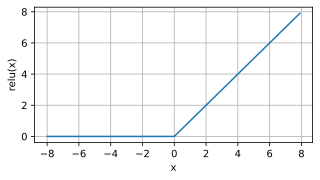

In [6]:
x = torch.arange(-8, 8, 0.1, requires_grad = True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize = (5, 2.5))

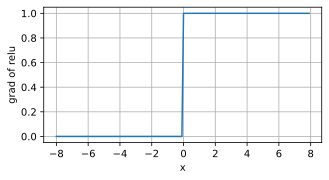

In [7]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### Sigmoid Function

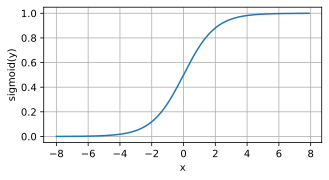

In [8]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(y)', figsize = (5, 2.5))

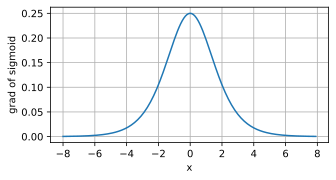

In [9]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function

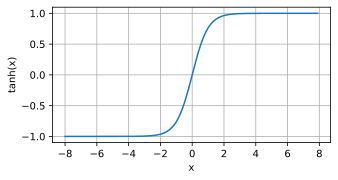

In [10]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize = (5, 2.5))

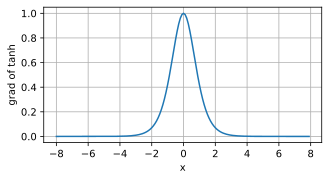

In [11]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

### Summary

- MLP adds one or multiple fully-connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.

- Commonly-used activation functions include the ReLU function, the sigmoid function, and the tanh function.

# 4.2. Implementation of Multilayer Perceptrons from Scratch

In [ ]:
from torch import nn

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### Initializing Model Parameters

In [14]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

### Activation Function

In [15]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### Model

In [16]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # Here '@' stands for matrix multiplication
    return (H@W2 + b2)

### Loss Function

In [17]:
loss = nn.CrossEntropyLoss(reduction = 'none')

### Training

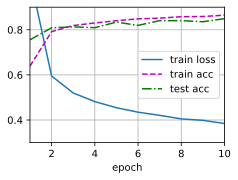

In [18]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


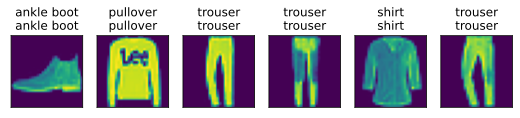

In [19]:
d2l.predict_ch3(net, test_iter)

### Summary

- We saw that implementing a simple MLP is easy, even when done manually.

- However, with a large number of layers, implementing MLPs from scratch can still get messy (e.g., naming and keeping track of our model’s parameters).

# 4.3. Concise Implementation of Multilayer Perceptrons

### Model

In [20]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

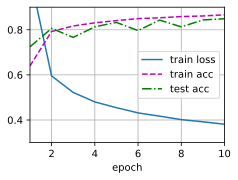

In [21]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### Summary

- Using high-level APIs, we can implement MLPs much more concisely.

- For the same classification problem, the implementation of an MLP is the same as that of softmax regression except for additional hidden layers with activation functions.

# 4.4. Model Selection, Underfitting, and Overfitting

### Polynomial Regression

In [22]:
import math
import numpy as np

In [23]:
# Generating the Dataset
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [24]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.1264],
         [ 1.3911]]),
 tensor([[ 1.0000e+00, -1.2637e-01,  7.9852e-03, -3.3637e-04,  1.0627e-05,
          -2.6860e-07,  5.6573e-09, -1.0213e-10,  1.6134e-12, -2.2654e-14,
           2.8629e-16, -3.2890e-18,  3.4637e-20, -3.3671e-22,  3.0394e-24,
          -2.5607e-26,  2.0225e-28, -1.5035e-30,  1.0556e-32, -7.0208e-35],
         [ 1.0000e+00,  1.3911e+00,  9.6756e-01,  4.4865e-01,  1.5603e-01,
           4.3410e-02,  1.0064e-02,  2.0001e-03,  3.4778e-04,  5.3755e-05,
           7.4778e-06,  9.4566e-07,  1.0962e-07,  1.1730e-08,  1.1656e-09,
           1.0809e-10,  9.3980e-12,  7.6903e-13,  5.9432e-14,  4.3513e-15]]),
 tensor([4.7108, 6.0418]))

In [25]:
# Training and Testing the Model
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [26]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9859     1.2591907 -3.4049385  5.4352446]]


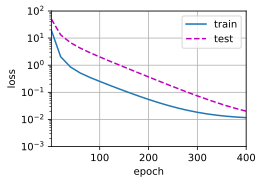

In [28]:
# Third-Order Polynomial Function Fitting (Normal)
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.506877  3.1191273]]


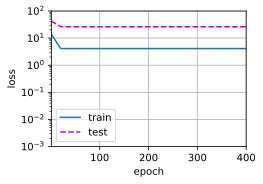

In [29]:
# Linear Function Fitting (Underfitting)
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9876943   1.2395082  -3.3746033   5.282109   -0.2114255   1.2842587
   0.01962142  0.36370453  0.05043653 -0.2052608  -0.22124398  0.02385842
  -0.20407847 -0.12149318 -0.07847778  0.16109975  0.20470174 -0.02161733
   0.11093884  0.12259293]]


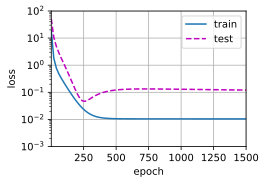

In [30]:
# Higher-Order Polynomial Function Fitting (Overfitting)
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

### Summary

- Since the generalization error cannot be estimated based on the training error, simply minimizing the training error will not necessarily mean a reduction in the generalization error. Machine learning models need to be careful to safeguard against overfitting so as to minimize the generalization error.

- A validation set can be used for model selection, provided that it is not used too liberally.

- Underfitting means that a model is not able to reduce the training error. When training error is much lower than validation error, there is overfitting.

- We should choose an appropriately complex model and avoid using insufficient training samples.

# 4.5. Weight Decay

### High-Dimensional Linear Regression

In [31]:
%matplotlib inline

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### Implementation from Scratch

In [32]:
# Initializing Model Parameters
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [33]:
# Defining  L_2  Norm Penalty
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [34]:
# Defining the Training Loop
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

L2 norm of w: 13.463582992553711


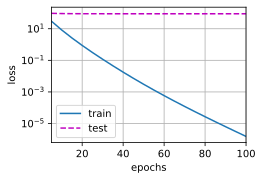

In [35]:
# Training without Regularization
train(lambd=0)

L2 norm of w: 0.38208451867103577


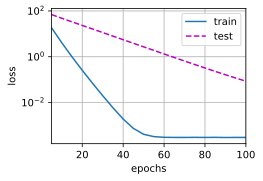

In [36]:
# Using Weight Decay
train(lambd=3)

### Concise Implementation

In [37]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 13.575708389282227


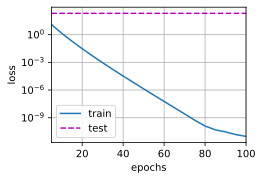

In [38]:
train_concise(0)

L2 norm of w: 0.44500088691711426


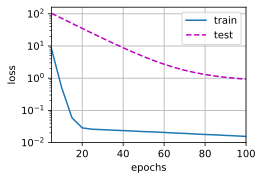

In [39]:
train_concise(3)

### Summary

- Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.

- One particular choice for keeping the model simple is weight decay using an  L_2  penalty. This leads to weight decay in the update steps of the learning algorithm.

- The weight decay functionality is provided in optimizers from deep learning frameworks.

- Different sets of parameters can have different update behaviors within the same training loop.